In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.autonotebook import tqdm as notebook_tqdm

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [215]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [216]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [217]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image Shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

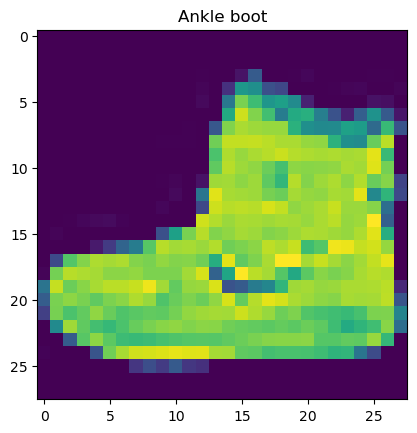

In [218]:
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(class_names[label])

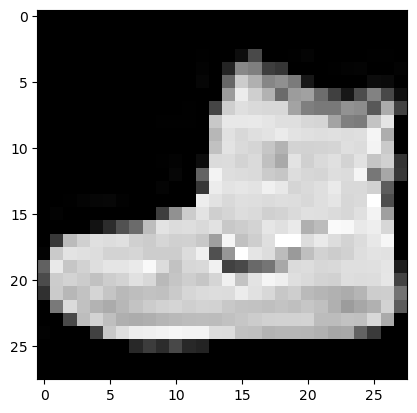

In [219]:
plt.imshow(image.squeeze(), cmap="gray")

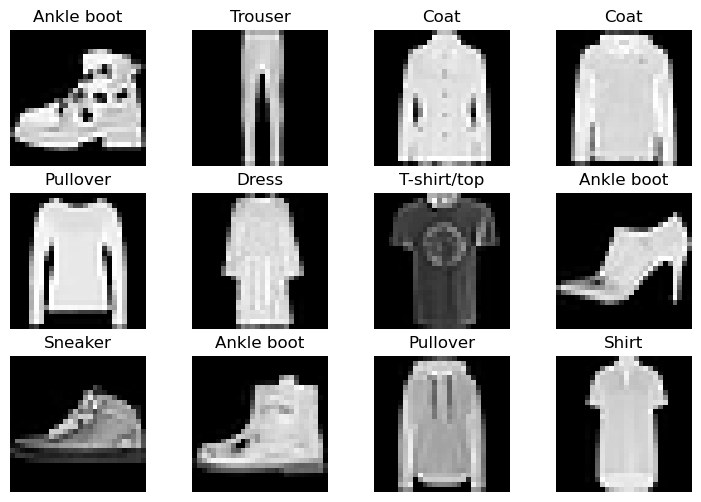

In [220]:
fig = plt.figure(figsize=(9,6))
rows, cols = 3, 4
for i in range(1, rows * cols + 1):
    rand = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(class_names[label])
    plt.axis(False)

In [221]:
batch_size = 128

train_size = 54_000
valid_size = 6000

train_dataset, valid_dataset = random_split(train_data, [train_size, valid_size])

In [222]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, 256, shuffle=False)
test_dataloader = DataLoader(test_data, 256, shuffle=False)

In [223]:
class MNIST_MLP(nn.Module):

    def __init__(self, img_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        
        self.nn_seq = nn.Sequential(
            nn.Linear(img_dim[0] * img_dim[1], 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.15),
            
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.nn_seq(x)
        return logits
    

In [224]:
model = MNIST_MLP((28,28)).to(device)
print(model)

MNIST_MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn_seq): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [225]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), 1e-3)

In [226]:
def acc_func(logits, y):
    preds = logits.argmax(dim=1)
    correct = (preds == y).sum().item()
    return correct / y.size(0)

In [227]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [228]:
def eval_model(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_func: nn.Module, acc_func):
    total_loss = 0
    total_correct = 0
    total_examples = 0
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            logits = model(X)
            loss = loss_func(logits, y)
            
            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_correct += (logits.argmax(dim=1) == y).sum().item()
            total_examples += batch_size
            
    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
        
    return avg_loss, avg_acc
            

In [229]:
def train_one_epoch(model: nn.Module, data_loader: torch.utils.data.DataLoader, optimizer, loss_func: nn.Module, device: torch.device):
    total_loss = 0
    total_correct = 0
    total_examples = 0
    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        logits = model(X)
        loss = loss_func(logits, y)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        batch_size = y.size(0)
        total_loss += loss.item() * batch_size
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_examples += batch_size
        
        if batch % 500 == 0:
            print(f"Looked at {batch * batch_size}/{len(data_loader.dataset)}")
            
    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
        
    return avg_loss, avg_acc

In [230]:
train_start = timer()

epochs = 25
best_val_acc = 0.0



for epoch in notebook_tqdm(range(epochs)):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, loss_func, device)
    val_loss, val_acc = eval_model(model, valid_dataloader, loss_func, acc_func)
    
    print(f"\nEpochs: {epoch:02d} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "mnist_best_acc.pt")
        print(f"Saved new best model with acc: {best_val_acc:.4f}")


train_end = timer()

total_train_time = print_train_time(train_start, train_end, device)

  0%|          | 0/25 [00:00<?, ?it/s]

Looked at 0/54000


  4%|▍         | 1/25 [00:02<00:58,  2.45s/it]


Epochs: 00 | Train Loss: 0.62176 | Train Acc: 0.7803 | Val Loss: 0.39300 | Val Acc: 0.8628
Saved new best model with acc: 0.8628
Looked at 0/54000


  8%|▊         | 2/25 [00:04<00:54,  2.37s/it]


Epochs: 01 | Train Loss: 0.41306 | Train Acc: 0.8509 | Val Loss: 0.35211 | Val Acc: 0.8723
Saved new best model with acc: 0.8723
Looked at 0/54000


 12%|█▏        | 3/25 [00:07<00:51,  2.35s/it]


Epochs: 02 | Train Loss: 0.37213 | Train Acc: 0.8649 | Val Loss: 0.33582 | Val Acc: 0.8775
Saved new best model with acc: 0.8775
Looked at 0/54000


 16%|█▌        | 4/25 [00:09<00:49,  2.35s/it]


Epochs: 03 | Train Loss: 0.34751 | Train Acc: 0.8737 | Val Loss: 0.33488 | Val Acc: 0.8738
Looked at 0/54000


 20%|██        | 5/25 [00:11<00:46,  2.34s/it]


Epochs: 04 | Train Loss: 0.33290 | Train Acc: 0.8768 | Val Loss: 0.33185 | Val Acc: 0.8775
Looked at 0/54000


 24%|██▍       | 6/25 [00:14<00:44,  2.34s/it]


Epochs: 05 | Train Loss: 0.31965 | Train Acc: 0.8822 | Val Loss: 0.30291 | Val Acc: 0.8880
Saved new best model with acc: 0.8880
Looked at 0/54000


 28%|██▊       | 7/25 [00:16<00:41,  2.32s/it]


Epochs: 06 | Train Loss: 0.30627 | Train Acc: 0.8865 | Val Loss: 0.29154 | Val Acc: 0.8930
Saved new best model with acc: 0.8930
Looked at 0/54000


 32%|███▏      | 8/25 [00:18<00:39,  2.32s/it]


Epochs: 07 | Train Loss: 0.29843 | Train Acc: 0.8898 | Val Loss: 0.29313 | Val Acc: 0.8893
Looked at 0/54000


 36%|███▌      | 9/25 [00:21<00:37,  2.33s/it]


Epochs: 08 | Train Loss: 0.28751 | Train Acc: 0.8944 | Val Loss: 0.29759 | Val Acc: 0.8910
Looked at 0/54000


 40%|████      | 10/25 [00:23<00:34,  2.32s/it]


Epochs: 09 | Train Loss: 0.28212 | Train Acc: 0.8945 | Val Loss: 0.30214 | Val Acc: 0.8907
Looked at 0/54000


 44%|████▍     | 11/25 [00:25<00:32,  2.33s/it]


Epochs: 10 | Train Loss: 0.27732 | Train Acc: 0.8977 | Val Loss: 0.28291 | Val Acc: 0.8923
Looked at 0/54000


 48%|████▊     | 12/25 [00:28<00:30,  2.32s/it]


Epochs: 11 | Train Loss: 0.26659 | Train Acc: 0.8998 | Val Loss: 0.29099 | Val Acc: 0.8932
Saved new best model with acc: 0.8932
Looked at 0/54000


 52%|█████▏    | 13/25 [00:30<00:27,  2.33s/it]


Epochs: 12 | Train Loss: 0.26079 | Train Acc: 0.9016 | Val Loss: 0.27850 | Val Acc: 0.8993
Saved new best model with acc: 0.8993
Looked at 0/54000


 56%|█████▌    | 14/25 [00:32<00:25,  2.32s/it]


Epochs: 13 | Train Loss: 0.25093 | Train Acc: 0.9061 | Val Loss: 0.30800 | Val Acc: 0.8870
Looked at 0/54000


 60%|██████    | 15/25 [00:34<00:23,  2.32s/it]


Epochs: 14 | Train Loss: 0.24779 | Train Acc: 0.9067 | Val Loss: 0.28019 | Val Acc: 0.8970
Looked at 0/54000


 64%|██████▍   | 16/25 [00:37<00:20,  2.31s/it]


Epochs: 15 | Train Loss: 0.24390 | Train Acc: 0.9085 | Val Loss: 0.28957 | Val Acc: 0.8992
Looked at 0/54000


 68%|██████▊   | 17/25 [00:39<00:18,  2.31s/it]


Epochs: 16 | Train Loss: 0.24296 | Train Acc: 0.9084 | Val Loss: 0.28409 | Val Acc: 0.8963
Looked at 0/54000


 72%|███████▏  | 18/25 [00:41<00:16,  2.31s/it]


Epochs: 17 | Train Loss: 0.23256 | Train Acc: 0.9115 | Val Loss: 0.27294 | Val Acc: 0.9042
Saved new best model with acc: 0.9042
Looked at 0/54000


 76%|███████▌  | 19/25 [00:44<00:13,  2.31s/it]


Epochs: 18 | Train Loss: 0.23228 | Train Acc: 0.9128 | Val Loss: 0.27388 | Val Acc: 0.9033
Looked at 0/54000


 80%|████████  | 20/25 [00:46<00:11,  2.31s/it]


Epochs: 19 | Train Loss: 0.22832 | Train Acc: 0.9134 | Val Loss: 0.26983 | Val Acc: 0.9052
Saved new best model with acc: 0.9052
Looked at 0/54000


 84%|████████▍ | 21/25 [00:48<00:09,  2.32s/it]


Epochs: 20 | Train Loss: 0.22444 | Train Acc: 0.9146 | Val Loss: 0.27748 | Val Acc: 0.9027
Looked at 0/54000


 88%|████████▊ | 22/25 [00:51<00:06,  2.32s/it]


Epochs: 21 | Train Loss: 0.21877 | Train Acc: 0.9165 | Val Loss: 0.29777 | Val Acc: 0.8992
Looked at 0/54000


 92%|█████████▏| 23/25 [00:53<00:04,  2.33s/it]


Epochs: 22 | Train Loss: 0.21541 | Train Acc: 0.9179 | Val Loss: 0.26885 | Val Acc: 0.9042
Looked at 0/54000


 96%|█████████▌| 24/25 [00:55<00:02,  2.33s/it]


Epochs: 23 | Train Loss: 0.20739 | Train Acc: 0.9213 | Val Loss: 0.26836 | Val Acc: 0.9082
Saved new best model with acc: 0.9082
Looked at 0/54000


100%|██████████| 25/25 [00:58<00:00,  2.33s/it]


Epochs: 24 | Train Loss: 0.20713 | Train Acc: 0.9209 | Val Loss: 0.27319 | Val Acc: 0.9073
Train time on cuda: 58.186 seconds
